In [0]:
!pip install google_images_download

In [0]:
from google_images_download import google_images_download 

In [0]:
response = google_images_download.googleimagesdownload() 
arguments = {"keywords":"Polar bears,black bears, teddy bears, grizzly bears","limit":100,"print_urls":True}
paths = response.download(arguments)
print(path)

In [17]:
!ls downloads/

'black bears'  ' grizzly bears'  'Polar bears'	' teddy bears'


In [0]:
!mv downloads/' grizzly bears' downloads/'grizzly bears'
!mv downloads/' teddy bears' downloads/'teddy bears'

In [0]:
def change_name(path, folder):
  pwd = os.getcwd()
  source = f'{path}/{folder}'
  for i, f in enumerate(os.listdir(source)):
    name, ext = os.path.splitext(f'{pwd}/{source}/{f}')
    os.rename(f'{pwd}/{source}/{f}', f'{pwd}/{source}/{i}.jpg')

In [0]:
change_name('downloads', 'grizzly bears')
change_name('downloads', 'Polar bears')
change_name('downloads', 'black bears')
change_name('downloads', 'teddy bears')

## Begin

In [0]:
from fastai.vision import *

In [0]:
path = Path('downloads')

In [0]:
def create_download(path, folder, file):
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)
  download_images(path/file, dest, max_pics=200)

In [0]:
folder = 'black'
file = 'black.csv'

In [0]:
folder = 'teddy'
file = 'teddies.csv'

In [0]:
folder = 'grizzly'
file = 'grizzly.csv'

In [7]:
path.ls()

[PosixPath('downloads/black bears'),
 PosixPath('downloads/grizzly bears'),
 PosixPath('downloads/teddy bears'),
 PosixPath('downloads/Polar bears'),
 PosixPath('downloads/models')]

In [0]:
classes = ['teddy', 'grizzly', 'black']

## Building Model

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(),
                                  size=224, num_workers=4)

In [0]:
data = data.normalize(imagenet_stats)

In [11]:
data.classes

['Polar bears', 'black bears', 'grizzly bears', 'teddy bears']

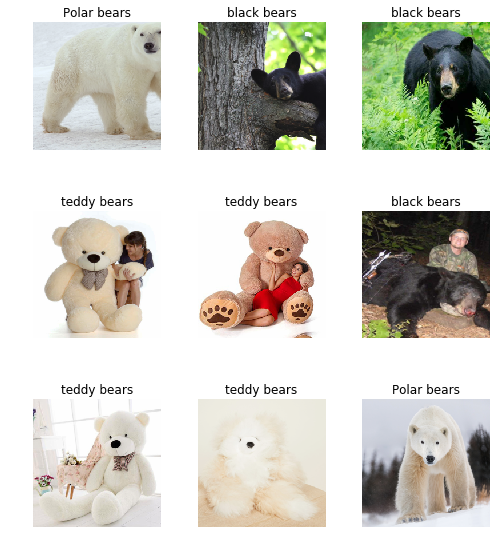

In [12]:
data.show_batch(rows=3, figsize=(7, 8))

In [13]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Polar bears', 'black bears', 'grizzly bears', 'teddy bears'], 4, 317, 79)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.404599,0.469237,0.151899,00:18
1,0.806553,0.147148,0.025316,00:17
2,0.554440,0.127560,0.025316,00:19
3,0.427831,0.129704,0.037975,00:17


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


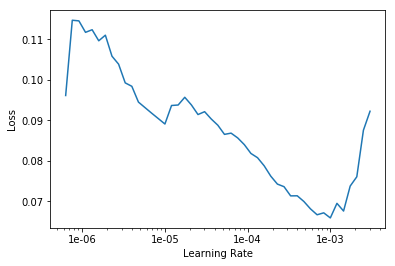

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.068984,0.126983,0.025316,00:18
1,0.080812,0.133519,0.025316,00:19


In [0]:
learn.save('stage-2')

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

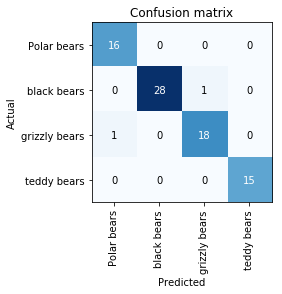

In [29]:
interp.plot_confusion_matrix()

In [0]:
# learn.TTA()

In [31]:
log_preds,y = learn.TTA()

In [0]:
probs = np.mean(np.exp(to_np(log_preds)),0)


In [47]:
accuracy(probs, y)

RuntimeError: ignored

In [38]:
to_np(y)

array([1, 3, 3, 1, ..., 1, 2, 1, 1])

In [0]:
torch.mean()

In [0]:
probs = torch.mean(torch.exp(log_preds), 1)

In [45]:
probs.shape

torch.Size([79])

In [46]:
y.shape

torch.Size([79])

In [43]:
log_preds.shape

torch.Size([79, 4])

In [0]:
y.view(79, 1).argmax(dim=-1).view(79,-1)

## Clean up

In [0]:
from fastai.widgets import *

In [52]:
db = (ImageList.from_folder(path)
                   .no_split()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:171: UserWarning: `no_split` is deprecated, please use `split_none`.
  warn("`no_split` is deprecated, please use `split_none`.")


In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [0]:
ImageCleaner(ds, idxs, path)